In [2]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.image as img
from PIL import Image
from statistics import mean
from itertools import product
from math import ceil

from numba import cuda, jit, int32, int64

from numpy import dstack
import skimage
import matplotlib.pyplot as plt

In [3]:
img = cv2.imread('lotos.jpg')
blue_ch, green_ch, red_ch = cv2.split(img)

def make_zeros(number):
    return [0] * number

In [8]:
@cuda.jit
def Bileteral_cuda(red, green, blue, res_red, res_green, res_blue, pixels):
  i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

  B = 200 #Значение 0 вернет изображение без изменений, значение 255 - это
  # гауссовское размытие. 
  # Промежуточные это чувствительность билетерального фильтра

  if i < len(red)*len(red[0]):
    n = int(i/len(red))
    c = int(i%len(red[0]))
    pn = n+1
    pc = c+1
    mn = n-1
    mc = c-1
  
    if pn == len(red): 
      pn = n
    if pc == len(red[0]): 
      pc = c

    pixels[0] = (red[n][c])
    pixels[1] = (red[n][pc])
    pixels[2] = (red[n][mc])
    pixels[3] = (red[pn][c])
    pixels[4] = (red[pn][pc])
    pixels[5] = (red[pn][mc])
    pixels[6] = (red[mn][c])
    pixels[7] = (red[mn][pc])
    pixels[8] = (red[mn][mc])

    summ = red[n][c]
    num = 1
    for r in range(1, 9):
      if abs(red[n][c] - pixels[r]) < B:
        summ+= pixels[r]
        num+=1

    px = summ/num
    res_red[n][c] = px

    pixels[0] = (green[n][c])
    pixels[1] = (green[n][pc])
    pixels[2] = (green[n][mc])
    pixels[3] = (green[pn][c])
    pixels[4] = (green[pn][pc])
    pixels[5] = (green[pn][mc])
    pixels[6] = (green[mn][c])
    pixels[7] = (green[mn][pc])
    pixels[8] = (green[mn][mc])

    gsumm = green[n][c]
    gnum = 1
    for g in range(8):
      if abs(green[n][c] - pixels[g]) < B:
        gsumm+= pixels[g]
        gnum+=1

    gpx = gsumm/gnum
    res_green[n][c] = gpx

    pixels[0] = (blue[n][c])
    pixels[1] = (blue[n][pc])
    pixels[2] = (blue[n][mc])
    pixels[3] = (blue[pn][c])
    pixels[4] = (blue[pn][pc])
    pixels[5] = (blue[pn][mc])
    pixels[6] = (blue[mn][c])
    pixels[7] = (blue[mn][pc])
    pixels[8] = (blue[mn][mc])

    bsumm = blue[n][c]
    bnum = 1
    for b in range(8):
      if abs(blue[n][c] - pixels[b]) < B:
        bsumm+= pixels[b]
        bnum+=1

    bpx = bsumm/bnum
    res_blue[n][c] = bpx

In [5]:
def DeviceHost (img):
  TPB = 1024
  blue_ch, green_ch, red_ch = cv2.split(img)

  bilet_blue = []
  count = 0
  for row in blue_ch:
    bilet_blue.append(make_zeros(len(blue_ch[0])))

  bilet_green = []
  count = 0
  for row in green_ch:
    bilet_green.append(make_zeros(len(green_ch[0])))

  bilet_red = []
  count = 0
  for row in red_ch:
    bilet_red.append(make_zeros(len(red_ch[0])))

  pixels = np.zeros(9)
  dev_pixels = cuda.to_device(pixels)
  dev_red = cuda.to_device(red_ch)
  dev_green = cuda.to_device(green_ch)
  dev_blue = cuda.to_device(blue_ch)
  dev_bilet_red = cuda.to_device(bilet_red)
  dev_bilet_green = cuda.to_device(bilet_green)
  dev_bilet_blue = cuda.to_device(bilet_blue)

  block = (TPB)
  blockgrid = ceil(int(img.size)/3/TPB)
  print(blockgrid)

  Bileteral_cuda[blockgrid, block](dev_red, dev_green, dev_blue, dev_bilet_red, dev_bilet_green, dev_bilet_blue, dev_pixels)
  return(dev_bilet_red.copy_to_host(), dev_bilet_green.copy_to_host(), dev_bilet_blue.copy_to_host())

In [6]:
redd, gren, blu = DeviceHost(img)

357


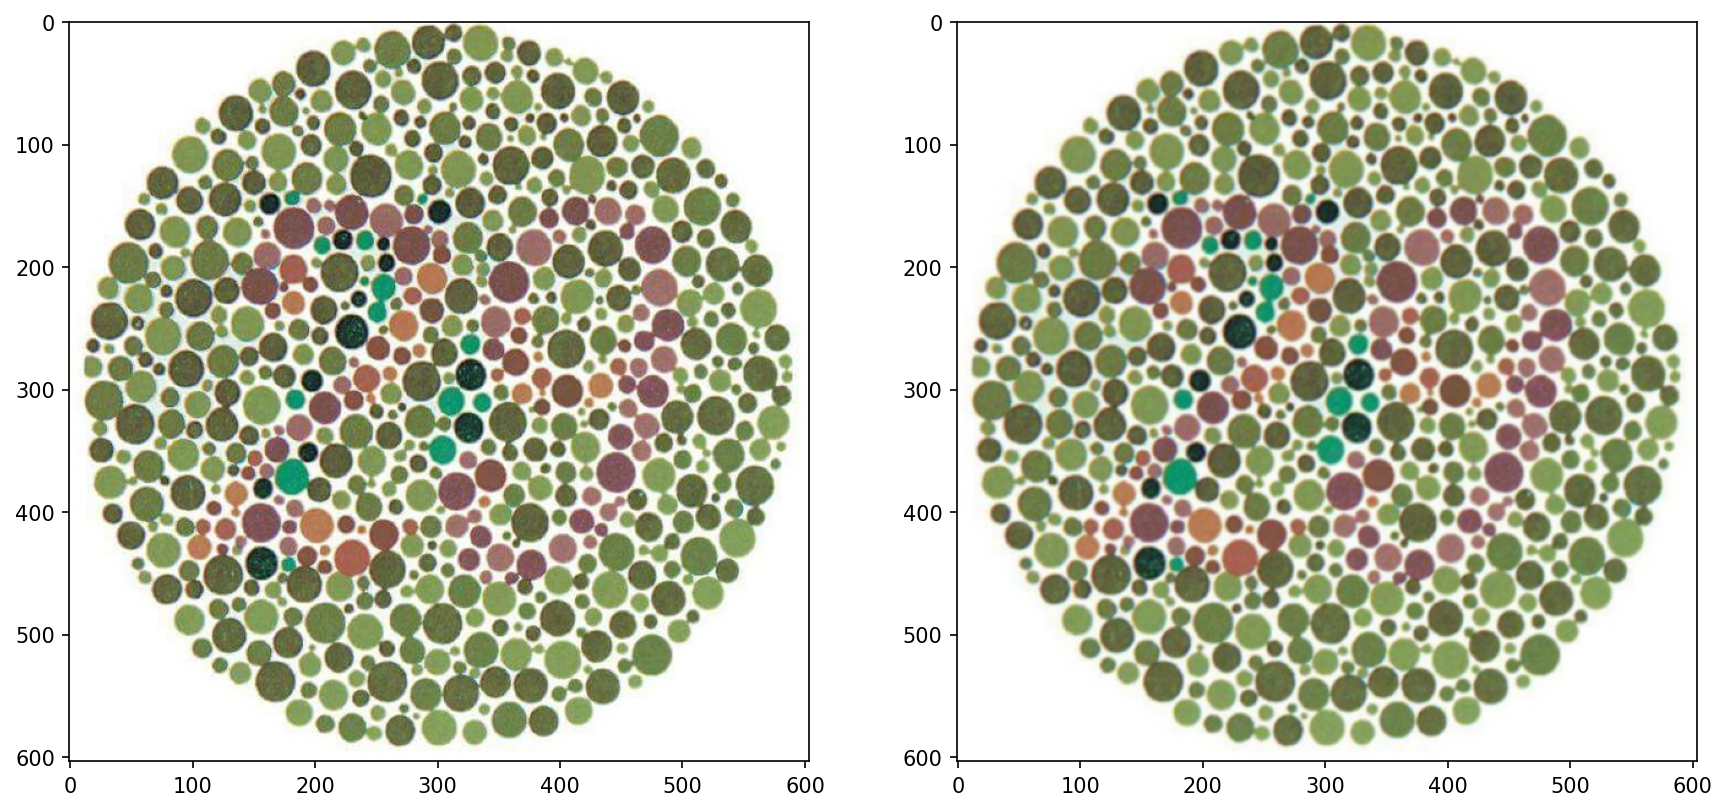

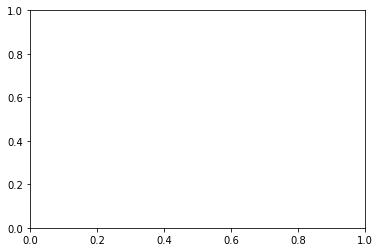

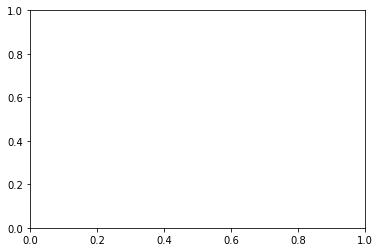

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), dpi=150)

img_f=dstack((red_ch,green_ch, blue_ch))
fig, ax = plt.subplots(1, 1)
ax1.imshow(img_f)

img_f=dstack((redd, gren, blu))
fig, ax = plt.subplots(1, 1)
ax2.imshow(img_f)

In [10]:
!screenfetch

                          ./+o+-       root@c1fa208f3aa2
                  yyyyy- -yyyyyy+      OS: Ubuntu 18.04 bionic
               ://+//////-yyyyyyo      Kernel: x86_64 Linux 5.4.104+
           .++ .:/++++++/-.+sss/`      Uptime: 18m
         .:++o:  /++++++++/:--:/-      Packages: 1396
        o:+o+:++.`..```.-/oo+++++/     Shell: python3
       .:+o:+o/.          `+sssoo+/    CPU: Intel Xeon @ 2x 2.3GHz
  .++/+:+oo+o:`             /sssooo.   GPU: Tesla K80
 /+++//+:`oo+o               /::--:.   RAM: 1151MiB / 12991MiB
 \+/+o+++`o++o               ++////.  
  .++.o+++oo+:`             /dddhhh.  
       .+.o+oo:.          `oddhhhh+   
        \+.++o+o``-````.:ohdhhhhh+    
         `:o+++ `ohhhhhhhhyo++os:     
           .o:`.syhhhhhhh/.oo++o`     
               /osyyyyyyo++ooo+++/    
                   ````` +oo+++o\:    
                          `oo++.      
